## Trainning a better model

In [1]:
%matplotlib inline
import utils
import imp
imp.reload(utils)
from utils import *
from __future__ import division, print_function

Using TensorFlow backend.


In [2]:
# path = "data/dogscats/sample/"
path = "data/redux/sample/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

#batch_size = 64
batch_size = 4

#fc_length = 16 * 14 * 14
fc_length = 16 * 16 * 16

## Are we underfitting?

Out validataion accuracy so far has generally been higher than out training accuracy. That leads to two obvious questions:

1. How is this possible?
2. Is this desirable?

The answer to (1) is taht this is happening because of *dropout*. Dropout refers to a layer that randomly deletes (i.e. sets to zero) ach activation in the previous layer with probability *p* (genarally 0.5). This only happens during training, not when calculating the accuracy onthe validation set, which is why the validation set can show higher accuracy than the training set.

The purpose of dropout is to avoid overfitting. By deleting pars of the neural wetowrk at random during training, it ensures that no one part of the network can overfit to one part of the training set. The creation of dropout was one of the key developments in deep learning, and has allowed us to create rich models without overfitting. However, it can also ersult in underfitting if overused, and this is something we should be careful of with our model.

So the answer to (2) is: this is probably not desirable. It is likely that we can get berrter validation set results with less (or no) dropout, if we're seeing that validation accuracy is higher thatn training accuracy - a strong sign of underfitting. So let's try removing dropouts entirely, and see what happens!

(We had dropout in this model alrady because the VGG authors found it necessary for the imagenet competition. But that doesn;t mean it's necessary for fogs vs cats, so we will do our anaaysis of regularization approaches from scratch.)

## Removing dropout

Our high level approach here will be start with our fine-tuned cats vs dogs model (with dropout), then fine-tune all the dense layers, after removing dropout from them. The steps we will take are:

- Re-create and load out modified VGG model with binary dependent (i.e. dogs vs cats)
- SPlit the model between the convolutional (*conv*) layers and the dense layers
- Pre-calculate the output of the conv layers, so that we don't have to redundently re-calculate them on every epoch
- Create a new model with just the dense layers, and dropout p set zero
- Train this new model using the output of the conv layers as training data.

As before we need to start with a working model, so let's bring in our working VGG 16 model and change it to predict our binary dependent...

In [14]:
model = vgg_ft(2)

... and load out fine-tuned weights.

In [15]:
# model.load_weights(model_path + 'finetune3.h5')
model.load_weights(model_path + 'finetune2.h5')

We are going to training a number of iterations without dropout, so it would be best for us to pre-calculate the inut to thte fully connected layers - i.e. the *Flatten()* layer. We'll start by finding this layer in out model, and creating an new model taht contains just the layers up to and including this layer.

In [16]:
layers = model.layers

In [17]:
last_conv_idx = [index for index, layer in enumerate(layers) if type(layer) is Convolution2D][-1]

In [18]:
last_conv_idx

30

In [19]:
layers[last_conv_idx]

In [20]:
conv_layers = layers[:(last_conv_idx + 1)]
conv_model = Sequential(conv_layers)

In [21]:
# Dense layers - also known as fully connected or 'FC' layers
fc_layers = layers[(last_conv_idx + 1):]

Now we can use the exact same approach to creating features as we used when we created the lilnear model from teh imagenet preictions int thelast lesson - it's onlt the model tha thas changed. As you're seeing, there;s a fairly a small number of "recipres' taht can get us a long way!

In [3]:
batches = get_batches(path + 'train', shuffle = False, batch_size = batch_size)
val_batches = get_batches(path + 'valid', shuffle = False, batch_size = batch_size)

val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [4]:
batches.class_indices

{'cats': 0, 'dogs': 1}

In [ ]:
val_features = conv_model.predict_generator(generator = val_batches, steps = val_batches.samples / batch_size)

In [ ]:
trn_features = conv_model.predict_generator(generator = batches, steps = batches.samples / batch_size)

In [ ]:
save_array(model_path + 'train_convlayer_features.bc', trn_features)
save_array(model_path + 'valid_convlayer_features.bc', val_features)

In [5]:
trn_features = load_array(model_path + 'train_convlayer_features.bc')
val_features = load_array(model_path + 'valid_convlayer_features.bc')

In [6]:
trn_features.shape

(200, 512, 14, 14)

In [7]:
trn_labels.shape

(200, 2)

In [8]:
val_features.shape

(50, 512, 14, 14)

In [9]:
val_labels.shape

(50, 2)

In [10]:
# Copy the weights from the pre-trained model.
# NB: Since we're removing dropout, we wnat to half the weights
def proc_wgts(layer):
    return [o/2 for o in layer.get_weights()]

In [11]:
# Such a finly tuned model needs to be updated very slowly!
opt = RMSprop(lr = 0.00001, rho = 0.7)

In [12]:
def get_fc_model() :
    model = Sequential([
        MaxPooling2D(input_shape = conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(fc_length, activation = 'relu'),
        Dropout(0.),
        Dense(fc_length, activation = 'relu'),
        Dropout(0.),
        Dense(2, activation = 'softmax')
    ])
    
    for l1, l2 in zip(model.layers, fc_layers): l1.set_weights(proc_wgts(l2))
        
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
model.summary()

In [22]:
fc_model = get_fc_model()

And fit the model in the usual way:

In [ ]:
fc_model.fit(trn_features, trn_labels, epochs = 8, batch_size = batch_size, validation_data = (val_features, val_labels))

In [ ]:
fc_model.save_weights(model_path + 'no_dropout.h5')

In [23]:
fc_model.load_weights(model_path + 'no_dropout.h5')

## Reducing overfitting

Now that we've gotton the model to overfit, we can take a number of steps to reduce this.

### Approaches to reducing overfitting

We do not necessarily need to erly on dropout or other regularization approaches to reduce overfitting. There are other techniques we should try first, since regularization, by definition, buases out model toward simpliity - which we only want to do if we know that;s necessary. This is the other taht we recommend using for reducing overfitting (more details about each in a moment):

1. Add more data
2. Use data augmentation
3. Use architectures taht generalize well
4. Add regularization
5. Reduce architecture complexity.

We'll assume that you've already already collected as much data as you can, so step (1) isn't relevant (this is true for most Kaggle competitions, for instance). So the next step (2) is data augmentation. This regfers to creating additional systethic data, based on readonable modificaions of yout input data. For images, this is likely to involve one or more of: flipping, rotation, zooming, cropping, panning, minor color changes.

Which types of augmentation are approapriate depends on your data. For regular photos, for instance, you'll want to use horizontal flipping, but not vertical flipping (since an updide down car is much less common than a car the tight way up, for instance!)

We recommend *always* using at least some lifht data augmentation, unless you have so much data that your model will never see the same input twice.

### About data augmentation

Keras comes with very convinient features for automating data augmentation. You simply define what types and maximum amounts of agumentation you want, and keras endsures that every item of every batch randomly is changed accordingly to these settings. Here's how to define a generator that includes data augmentation:

In [24]:
# dim_orderinf = 'tf' uses tensorflow dimmension ordering
# which is the same order as matplotlib uses for display.
# Therefore when hust using for display purposes, this is more convinient
#gen = image.ImageDataGenerator(rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1, shear_range = 0.15, zoom_range = 0.1, channel_shift_range = 10, horizontal_flip = True, dim_ordering = 'tf')
gen = image.ImageDataGenerator(rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1, shear_range = 0.15, zoom_range = 0.1, channel_shift_range = 10, horizontal_flip = True, data_format = "channels_last")

Let's take a look at how this generator changes a single image (the details of this code don't matter much, but feel free to read the comments and keras docs to understand the details if you're interested).

In [25]:
# Create a 'batch' of a single image
img = np.expand_dims(ndimage.imread(path + 'test/7.jpg'), 0)
# Request the generator to create batches from this mage
aug_iter = gen.flow(img)

In [26]:
# Get eight examples of these augmented images
aug_imgs = [next(aug_iter)[0].astype(np.int8) for i in range(8)]

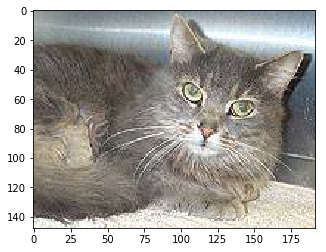

In [27]:
# The original
plt.imshow(img[0])

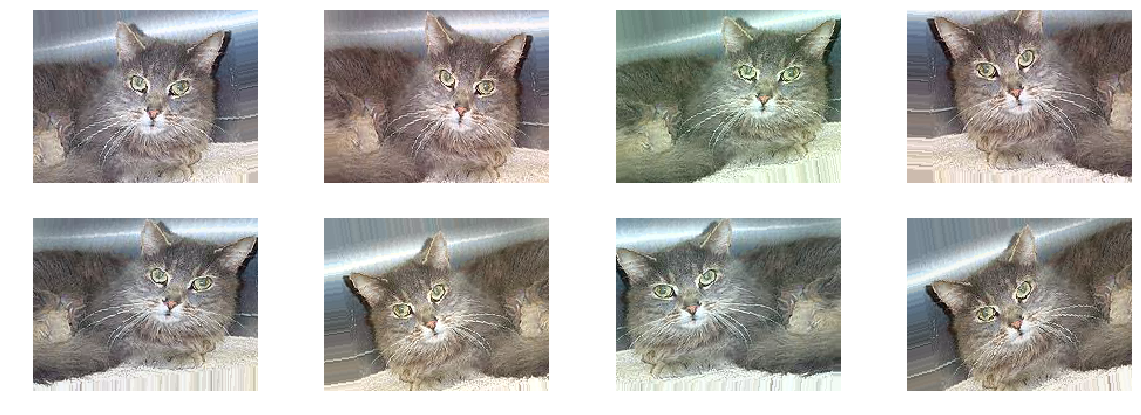

In [28]:
# Augmented_data
plots(aug_imgs, (20, 7), 2)

In [29]:
# Ensure taht we return to theano dimension ordering
K.set_image_dim_ordering('th')

### Adding data augmentation

Let's try adding a small amount of data augmentation, andn see if we reduce overfitting as a result. The approach will be identicalt o the method we used to finetune the dense layeys in lesson 2, except tha twe will use a generator with augmentation configured. Here's how we setup the generator, and create batches from it:

In [30]:
gen = image.ImageDataGenerator(rotation_range = 15, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.1, horizontal_flip = True)

In [31]:
batches = get_batches(path + 'train', gen, batch_size = batch_size)
# NBL We don't want to augment or shuffle the validation set
val_batches = get_batches(path + 'valid', shuffle = False, batch_size = batch_size)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


When using data augmentation, we can't pre-compute out convolutional layer features, since randomized changes are being made to every input image. That is, even if the training process sees the same image multiple time, each time it will have undergone different data augmentation, so the results of the convolutional layers will be different.

Therefore, in order to alow data to flow through all the conv layers and our new dense layers, we attach out fully connected model to the convolutional model -- after ensuring that the convolutional layers are not trainable:

In [32]:
fc_model = get_fc_model()

In [33]:
for layer in conv_model.layers: layer.trainable = False
# Look how easy it is to connect two models together!
conv_model.add(fc_model)

Now we can compile, train, and save our models as usual - note that we use *fit_generator()* since we want to pull random images from the directories on every batch.

In [34]:
conv_model.compile(optimizer =opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# conv_model.fit_generator(batches, samples_per_epoch = batches.samples, epochs = 8, validation_data = val_batches, nb_val_samples = val_batches.samples)
conv_model.fit_generator(batches, steps_per_epoch = batches.samples / batch_size, epochs = 8, validation_data = val_batches, validation_steps = val_batches.samples / batch_size)

In [ ]:
# conv_model.fit_generator(batche, samples_per_epoch = batches.nb_sample, epochs = 3, validation_data = val_batches, nb_val_samples = val_batches.samples)
conv_model.fit_generator(batches, steps_per_epoch = batches.samples / batch_size, epochs = 3, validation_data = val_batches, validation_steps = val_batches.samples / batch_size)

In [ ]:
conv_model.save_weights(model_path + 'aug1.h5')

In [35]:
conv_model.load_weights(model_path + 'aug1.h5')

## Batch normalization

### About batch normalization

Batch normalization (*batchnorm*) is a way to ensure that activations don;t become too high or too low at any point in the model. Adjusting activations so they are similar scales is called *normalization*. Normalization is very helpful for fast training - if some activations are bery high, they will saturate the model and create very large gradients, causing training to fail; if very low, they will cause training to proceed very slowly. Furthermore, large or small activations in one layer will tend to result in even larger or smaller activations in later layers, since the activations het multiplied repeatedly across th e layers.

Prior to the development of abtnorm in 2015, only yhe inputs to a model could be effectively normalized - by simply subtracting their mean and dividing by their standard deviation. However, wieghts in intermediate layers could easily become poorly scaled, due to problems in weight initialization, or a high learning rate combined with random fluctuations in wieghts.

Batchnorm resolves this problem by normalizing each intermediate layers as well. The details of how it works are not terribly important (although Iwll outline them in a monment) - the important takaway is that **all modern networks should use batchnorm, or something equivalent**. There are two erasons for this:

1. Adding batchnorm to ao model can result in **10x or more improvements in training speed**
2. Because normalization greatly reduces the ability of a small number of outlying inputs to over-influence the training, it also tends to **reduce overfitting**.

As promised, here's a brief outlien of how batchnorm works. As a first step, it normalizes intermediate layers in the same way as inpu t layers can be normalized. But this on its own would not be enough, since the model would then just push the weights up or down indefinitely to try to unde this normalization. Therefore, batchnorm takes two additional steps:

1. Add two more trainable parameters to each layers - on to multiply all activations to set an arbitary standard deviation, and ont o add to all activations to set an arbitary mean
2. Incorporate both the normalization, and the learnt multiply/add parameters, into the gradient calculations during backprop.

This ensures that the weights don't tend to push very high or very low (since the normalization is included in the gradient calculations, so the updates are aware of the normalization). But it also ensures that if a layer does need to change the overall mean or standard deciation in roder to match the output scale, it can do so.

### Adding batchnorm to the model

We can use nearly the same approach as before - but this time we'll add batchnorm layers (adn dropout layers):

In [36]:
conv_layers[-1].output_shape[1:]

(512, 14, 14)

In [37]:
def get_bn_layers(p) :
    return [
        MaxPooling2D(input_shape = conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(fc_length, activation = 'relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(fc_length, activation = 'relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1000, activation = 'softmax')
    ]

In [38]:
def load_fc_weights_from_vgg16bn(model):
    'Load weights for model from the dense layers of the Vgg16BN model'
    # See imagenet_batchnorm.ipynb for info on how the iehghts for
    # vgg16bn can be generated from the standard vgg16 weights.
    from vgg16bn import Vgg16BN
    vgg16_bn = Vgg16BN()
    _, fc_layers = split_at(vgg16_bn.model, Convolution2D)
    copy_weights(fc_layers, model.layers)


In [39]:
p = 0.6

In [40]:
bn_model = Sequential(get_bn_layers(0.6))

In [41]:
load_fc_weights_from_vgg16bn(bn_model)

In [42]:
def proc_wgts(layer, prev_p, new_p) :
    scal = (1-prev_p)/(1-new_p)
    return [o*scal for o in layer.get_weights()]

In [43]:
for l in bn_model.layers:
    if type(l) == Dense: l.set_weights(proc_wgts(l, 0.5, 0.6))

In [44]:
bn_model.pop()
for layer in bn_model.layers: layer.trainable = False

In [45]:
bn_model.add(Dense(2, activation = 'softmax'))

In [46]:
bn_model.compile(Adam(), 'categorical_crossentropy', metrics = ['accuracy'])

In [47]:
print(trn_features.shape)
print(trn_labels.shape)
print(val_features.shape)
print(val_labels.shape)
bn_model.summary()
opt

(200, 512, 14, 14)
(200, 2)
(50, 512, 14, 14)
(50, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_8 (MaxPooling2 (None, 512, 7, 7)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 4096)              102764544 
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)              16384     
_________________________________________________________________
dropout_7 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_2 

In [49]:
bn_model.fit(trn_features, trn_labels, epochs = 8, validation_data = (val_features, val_labels))

Train on 200 samples, validate on 50 samples
Epoch 1/8
200/200 [==============================] - 5s - loss: 2.4507 - acc: 0.5500 - val_loss: 0.9046 - val_acc: 0.8400
Epoch 2/8
200/200 [==============================] - 3s - loss: 1.0467 - acc: 0.7500 - val_loss: 0.6414 - val_acc: 0.8200
Epoch 3/8
200/200 [==============================] - 3s - loss: 0.7792 - acc: 0.8100 - val_loss: 0.6185 - val_acc: 0.8400
Epoch 4/8
200/200 [==============================] - 3s - loss: 0.7931 - acc: 0.8550 - val_loss: 0.6516 - val_acc: 0.8800
Epoch 5/8
200/200 [==============================] - 3s - loss: 0.4058 - acc: 0.8900 - val_loss: 0.6482 - val_acc: 0.8800
Epoch 6/8
200/200 [==============================] - 3s - loss: 0.6939 - acc: 0.8700 - val_loss: 0.6307 - val_acc: 0.8800
Epoch 7/8
200/200 [==============================] - 3s - loss: 0.5372 - acc: 0.8750 - val_loss: 0.3975 - val_acc: 0.9000
Epoch 8/8
200/200 [==============================] - 3s - loss: 0.4243 - acc: 0.9000 - val_loss: 0.35

In [50]:
bn_model.save_weights(model_path + 'bn.h5')

In [51]:
bn_model.load_weights(model_path + 'bn.h5')

In [52]:
bn_layers = get_bn_layers(0.6)
bn_layers.pop()
bn_layers.append(Dense(2, activation = 'softmax'))

In [54]:
final_model = Sequential(conv_layers)
for layer in final_model.layers: layer.trainable = False
for layer in bn_layers: final_model.add(layer)

In [55]:
for l1, l2 in zip(bn_model.layers, bn_layers):
    l2.set_weights(l1.get_weights())

In [57]:
final_model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [58]:
#final_model.fit_generator(batches, samples_per_epoch = batches.samples, nb_epoch = 1, validation_data = val_batches, nb_val_samples = val_batches.samples)
final_model.fit_generator(batches, steps_per_epoch = batches.n, nb_epoch = 1, validation_data = val_batches, validation_steps = val_batches.n)

C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=50, epochs=1, validation_steps=50)`
  """Entry point for launching an IPython kernel.


Epoch 1/1
50/50 [==============================] - 1125s - loss: 4.3483 - acc: 0.6550 - val_loss: 3.6157 - val_acc: 0.7732


In [59]:
final_model.save_weights(model_path + 'final1.h5')

In [61]:
final_model.fit_generator(batches, steps_per_epoch = batches.samples / batch_size, nb_epoch = 4, validation_data = val_batches, validation_steps = val_batches.samples / batch_size)

C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=50.0, validation_data=<keras.pre..., validation_steps=12.5, epochs=4)`
  """Entry point for launching an IPython kernel.


Epoch 1/4
50/50 [==============================] - 757s - loss: 4.2120 - acc: 0.7150 - val_loss: 3.7069 - val_acc: 0.7200
Epoch 2/4
50/50 [==============================] - 791s - loss: 3.3127 - acc: 0.7700 - val_loss: 2.8092 - val_acc: 0.8000
Epoch 3/4
50/50 [==============================] - 755s - loss: 3.2638 - acc: 0.7800 - val_loss: 3.6071 - val_acc: 0.7600
Epoch 4/4
50/50 [==============================] - 770s - loss: 2.9076 - acc: 0.7950 - val_loss: 2.0769 - val_acc: 0.8600


In [62]:
final_model.save_weights(model_path + 'final2.h5')

In [63]:
final_model.optimizer.lr = 0.001

In [ ]:
final_model.fit_generator(batches, steps_per_epoch = batches.samples / batch_size, epochs = 4, validation_data = val_batches, validation_steps = val_batches.sampels / batch_size)

Epoch 1/4
50/50 [==============================] - 1134s - loss: 3.1834 - acc: 0.7850 - val_loss: 3.5568 - val_acc: 0.6959
Epoch 2/4
50/50 [==============================] - 1083s - loss: 2.9683 - acc: 0.7950 - val_loss: 3.1987 - val_acc: 0.7784
Epoch 3/4
50/50 [==============================] - 1073s - loss: 2.7359 - acc: 0.7950 - val_loss: 2.6534 - val_acc: 0.8196
Epoch 4/4
50/50 [==============================] - 1085s - loss: 3.4280 - acc: 0.7650 - val_loss: 1.9588 - val_acc: 0.8608


In [ ]:
bn_model.save_weights(model_path + 'final3.h5')